# PFNS Sampling Comparison

This notebook compares:
- **Nominal** PFNS data from JEFF-4.0
- **Sampled** PFNS data generated by SANDY
- **Expected** uncertainties from MF35 covariance
- **Empirical** uncertainties from samples

In [1]:
import sys
sys.path.append('/home/pierre/codes/temp/ENDFtk/build/python')
import ENDFtk
from ENDFtk.tree import Tape
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import glob

# File paths
nominal_file = '/home/pierre/Projects/LIB/JEFF40/n_92-U-235g.jeff'
sampled_dir = '/home/pierre/codes/NuclearDataSampler/notebooks/VnV'
sampled_pattern = '*.endf'

print(f"Nominal file: {nominal_file}")
print(f"Sampled files directory: {sampled_dir}")
print(f"Pattern: {sampled_pattern}")

Nominal file: /home/pierre/Projects/LIB/JEFF40/n_92-U-235g.jeff
Sampled files directory: /home/pierre/codes/NuclearDataSampler/notebooks/VnV
Pattern: *.endf


In [3]:
nominal_file = '/home/pierre/Projects/LIB/JEFF40/n_92-U-235g.jeff'
endf_tape = Tape.from_file(nominal_file)
mf3 = endf_tape.materials.front().MF(3)

## Drawing Sampler

In [6]:
from ENDFtk.tree import Tape
from ndsampler import NDSampler, SamplerSettings, generate_covariance_dict
import numpy as np
import glob
import matplotlib.pyplot as plt

endf_tape = Tape.from_file(nominal_file)
covariance_dict = generate_covariance_dict(endf_tape)
del covariance_dict[31]
del covariance_dict[33]
# del covariance_dict[34]
# del covariance_dict[32][151][1] #No URR
# del covariance_dict[35]
covariance_dict

{35: {18: None}}

In [8]:
samplerSettings = SamplerSettings(sampling='Simple', widths_to_reduced=False)
sampler = NDSampler(nominal_file, covariance_dict=covariance_dict, settings=samplerSettings)
sampler.sample(num_samples = 15)

Generating 15 samples using Simple method...


## Load Nominal Data

In [9]:
# Read nominal PFNS data (MF5)
nominal_tape = ENDFtk.tree.Tape.from_file(nominal_file)
nominal_mat = nominal_tape.material(nominal_tape.material_numbers[0])
nominal_pfns_data = nominal_mat.MF(5).MT(18).parse()
nominal_pfns = nominal_pfns_data.partial_distributions[0].distribution

print(f"Nominal PFNS loaded:")
print(f"  Number of incident energies: {nominal_pfns.number_incident_energies}")

# Also load MF35 for expected uncertainties
try:
    nominal_pfns_unc = nominal_mat.MF(35).MT(18).parse()
    print(f"  MF35 covariance loaded: {nominal_pfns_unc.number_energy_blocks} blocks")
    has_covariance = True
except:
    print(f"  No MF35 covariance data available")
    has_covariance = False

Nominal PFNS loaded:
  Number of incident energies: 96
  MF35 covariance loaded: 8 blocks


## Load Sampled Data

In [11]:
# Find all sampled files
sampled_files = sorted(glob.glob(f"{sampled_pattern}"))

In [12]:
# Load PFNS data from all sampled files (only index 0 distribution)
sampled_probs_list = []

print(f"Loading PFNS data from {len(sampled_files)} samples (incident energy index 0 only)...")
for i, sample_file in enumerate(sampled_files):
    try:
        tape = ENDFtk.tree.Tape.from_file(sample_file)
        mat = tape.material(tape.material_numbers[0])
        pfns_data = mat.MF(5).MT(18).parse()
        pfns = pfns_data.partial_distributions[0].distribution
        
        # Extract only index 0 distribution
        pdf_sample = pfns.outgoing_distributions[0]
        probs = np.array(pdf_sample.probabilities.to_list())
        sampled_probs_list.append(probs)
        
        if (i+1) % 10 == 0 or (i+1) == len(sampled_files):
            print(f"  Loaded {i+1}/{len(sampled_files)} samples")
    except Exception as e:
        print(f"  ⚠️  Failed to load {Path(sample_file).name}: {str(e)[:50]}")

print(f"\n✓ Successfully loaded {len(sampled_probs_list)} sampled PFNS distributions")

Loading PFNS data from 16 samples (incident energy index 0 only)...
  Loaded 10/16 samples
  Loaded 16/16 samples

✓ Successfully loaded 16 sampled PFNS distributions


## Extract Nominal Data at Incident Energy Index 0

In [13]:
# Use incident energy index 0
incident_energy_idx = 0

nominal_pdf = nominal_pfns.outgoing_distributions[incident_energy_idx]
incident_energy = nominal_pdf.incident_energy

print(f"Selected incident energy index: {incident_energy_idx}")
print(f"  Incident energy: {incident_energy:.2e} eV = {incident_energy/1e6:.3f} MeV")

# Extract nominal PFNS
nominal_energies = np.array(nominal_pdf.outgoing_energies.to_list())
nominal_probs = np.array(nominal_pdf.probabilities.to_list())

print(f"\nNominal PFNS:")
print(f"  Outgoing energy range: [{nominal_energies.min():.2e}, {nominal_energies.max():.2e}] eV")
print(f"  Number of points: {len(nominal_energies)}")
print(f"\nSampled PFNS:")
print(f"  Number of samples: {len(sampled_probs_list)}")

Selected incident energy index: 0
  Incident energy: 1.00e-05 eV = 0.000 MeV

Nominal PFNS:
  Outgoing energy range: [1.00e-05, 3.00e+07] eV
  Number of points: 303

Sampled PFNS:
  Number of samples: 16


## Compute Statistics

In [14]:
# Stack all sampled probabilities
sampled_probs_array = np.array(sampled_probs_list)  # Shape: (n_samples, n_energy_points)

# Compute sample statistics
sample_mean = np.mean(sampled_probs_array, axis=0)
sample_std = np.std(sampled_probs_array, axis=0, ddof=1)
sample_rel_std = sample_std / sample_mean  # Relative standard deviation

# Compute percent difference: (sample - nominal) / nominal * 100
percent_diff_individual = (sampled_probs_array - nominal_probs) / nominal_probs * 100
percent_diff_mean = (sample_mean - nominal_probs) / nominal_probs * 100

print(f"Sample statistics computed:")
print(f"  Sample mean range: [{sample_mean.min():.3e}, {sample_mean.max():.3e}]")
print(f"  Sample std dev range: [{sample_std.min():.3e}, {sample_std.max():.3e}]")
print(f"  Sample relative std dev: [{sample_rel_std.min()*100:.2f}%, {sample_rel_std.max()*100:.2f}%]")
print(f"  Mean percent difference: [{percent_diff_mean.min():.2f}%, {percent_diff_mean.max():.2f}%]")

Sample statistics computed:
  Sample mean range: [1.331e-16, 3.574e-07]
  Sample std dev range: [0.000e+00, 1.094e-22]
  Sample relative std dev: [0.00%, 0.00%]
  Mean percent difference: [-0.00%, 0.00%]


## Extract Expected Uncertainties from MF35

In [15]:
if has_covariance:
    # Find the covariance block that covers our incident energy
    block_idx = None
    for i in range(nominal_pfns_unc.number_energy_blocks):
        block = nominal_pfns_unc.energy_blocks[i]
        if block.E1 <= incident_energy <= block.E2:
            block_idx = i
            break
    
    if block_idx is not None:
        block = nominal_pfns_unc.energy_blocks[block_idx]
        print(f"Found covariance block {block_idx}:")
        print(f"  Energy range: [{block.E1:.2e}, {block.E2:.2e}] eV")
        print(f"  LB flag: {block.LB} ({'Absolute' if block.LB == 7 else 'Relative' if block.LB == 5 else 'Unknown'})")
        
        # Extract covariance matrix
        NE_block = block.NE - 1
        values_block = block.values[:]
        cov_matrix = np.zeros((NE_block, NE_block))
        triu_indices = np.triu_indices(NE_block)
        cov_matrix[triu_indices] = values_block
        cov_matrix[(triu_indices[1], triu_indices[0])] = values_block
        
        # Energy grid for uncertainties
        unc_energies = np.array(block.energies[:])
        bin_edges = unc_energies
        
        # Integrate nominal PFNS over covariance bins
        pfns_yields_integrated = np.zeros(len(bin_edges)-1)
        for i in range(len(bin_edges)-1):
            bin_lower = bin_edges[i]
            bin_upper = bin_edges[i+1]
            mask = (nominal_energies >= bin_lower) & (nominal_energies < bin_upper)
            
            if np.any(mask):
                E_in_bin = nominal_energies[mask]
                P_in_bin = nominal_probs[mask]
                if len(E_in_bin) > 1:
                    pfns_yields_integrated[i] = np.trapezoid(P_in_bin, E_in_bin)
                else:
                    pfns_yields_integrated[i] = P_in_bin[0] * (bin_upper - bin_lower)
            else:
                P_lower = np.interp(bin_lower, nominal_energies, nominal_probs)
                P_upper = np.interp(bin_upper, nominal_energies, nominal_probs)
                pfns_yields_integrated[i] = 0.5 * (P_lower + P_upper) * (bin_upper - bin_lower)
        
        # Normalize
        pfns_yields_integrated = pfns_yields_integrated / np.sum(pfns_yields_integrated)
        
        # Extract standard deviations
        std_devs_cov = np.sqrt(np.diag(cov_matrix))
        
        # Convert to relative uncertainties based on LB flag
        if block.LB == 7:  # Absolute covariance
            expected_rel_unc = std_devs_cov / pfns_yields_integrated
        elif block.LB == 5:  # Relative covariance
            expected_rel_unc = std_devs_cov
        else:
            expected_rel_unc = std_devs_cov / pfns_yields_integrated  # Default to absolute interpretation
        
        # Map to nominal energy grid for plotting
        expected_rel_unc_mapped = np.zeros_like(nominal_energies)
        for i in range(len(bin_edges)-1):
            bin_lower = bin_edges[i]
            bin_upper = bin_edges[i+1]
            mask = (nominal_energies >= bin_lower) & (nominal_energies < bin_upper)
            expected_rel_unc_mapped[mask] = expected_rel_unc[i]
        
        # Handle boundary points
        mask_below = nominal_energies < bin_edges[0]
        mask_above = nominal_energies >= bin_edges[-1]
        if np.any(mask_below):
            expected_rel_unc_mapped[mask_below] = expected_rel_unc[0]
        if np.any(mask_above):
            expected_rel_unc_mapped[mask_above] = expected_rel_unc[-1]
        
        print(f"  Expected relative uncertainty: [{expected_rel_unc.min()*100:.2f}%, {expected_rel_unc.max()*100:.2f}%]")
    else:
        print(f"⚠️  No covariance block covers incident energy {incident_energy:.2e} eV")
        has_covariance = False
else:
    print("No covariance data available")

Found covariance block 0:
  Energy range: [0.00e+00, 1.00e+03] eV
  LB flag: 7 (Absolute)
  Expected relative uncertainty: [0.20%, 33.01%]


## Plot 1: Superposed PFNS Spectra

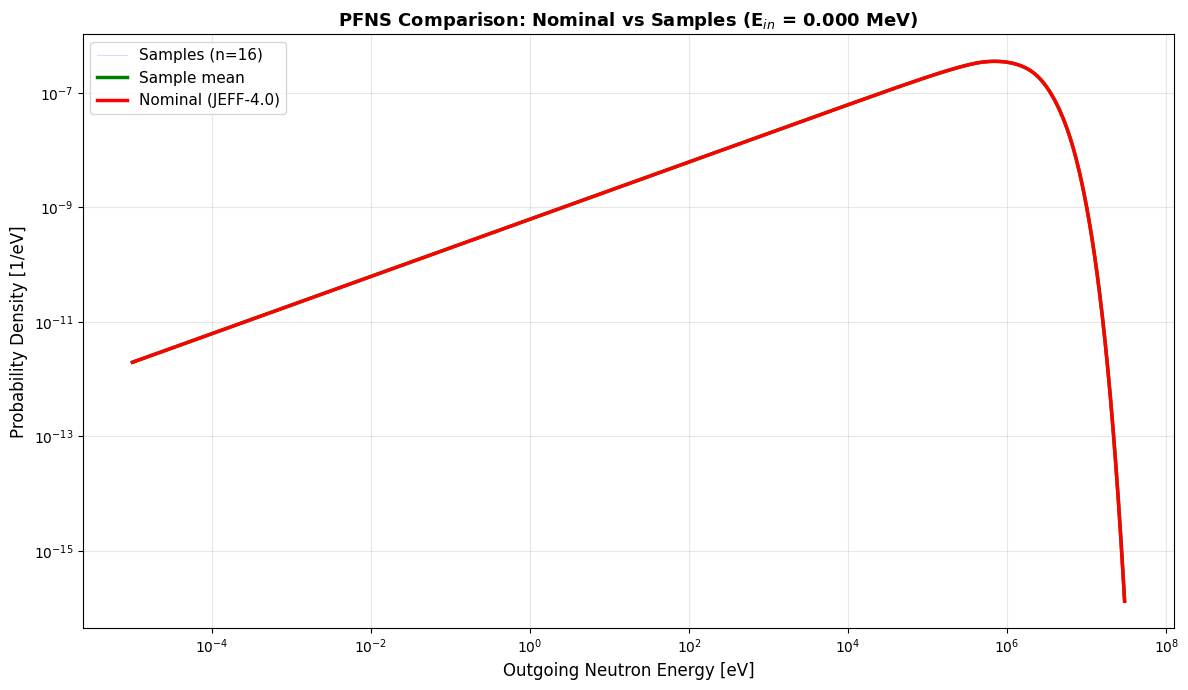

In [16]:
fig, ax = plt.subplots(figsize=(12, 7))

# Plot all samples with low alpha
for i, probs in enumerate(sampled_probs_list):
    if i == 0:
        ax.plot(nominal_energies, probs, 'b-', alpha=0.15, linewidth=0.8, label=f'Samples (n={len(sampled_probs_list)})')
    else:
        ax.plot(nominal_energies, probs, 'b-', alpha=0.15, linewidth=0.8)

# Plot sample mean
ax.plot(nominal_energies, sample_mean, 'g-', linewidth=2.5, label='Sample mean', zorder=10)

# Plot nominal
ax.plot(nominal_energies, nominal_probs, 'r-', linewidth=2.5, label='Nominal (JEFF-4.0)', zorder=10)

ax.set_xlabel('Outgoing Neutron Energy [eV]', fontsize=12)
ax.set_ylabel('Probability Density [1/eV]', fontsize=12)
ax.set_title(f'PFNS Comparison: Nominal vs Samples (E$_{{in}}$ = {incident_energy/1e6:.3f} MeV)', 
             fontsize=13, fontweight='bold')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
%matplotlib widget

## Plot 2: Percent Difference (Sample Mean vs Nominal)

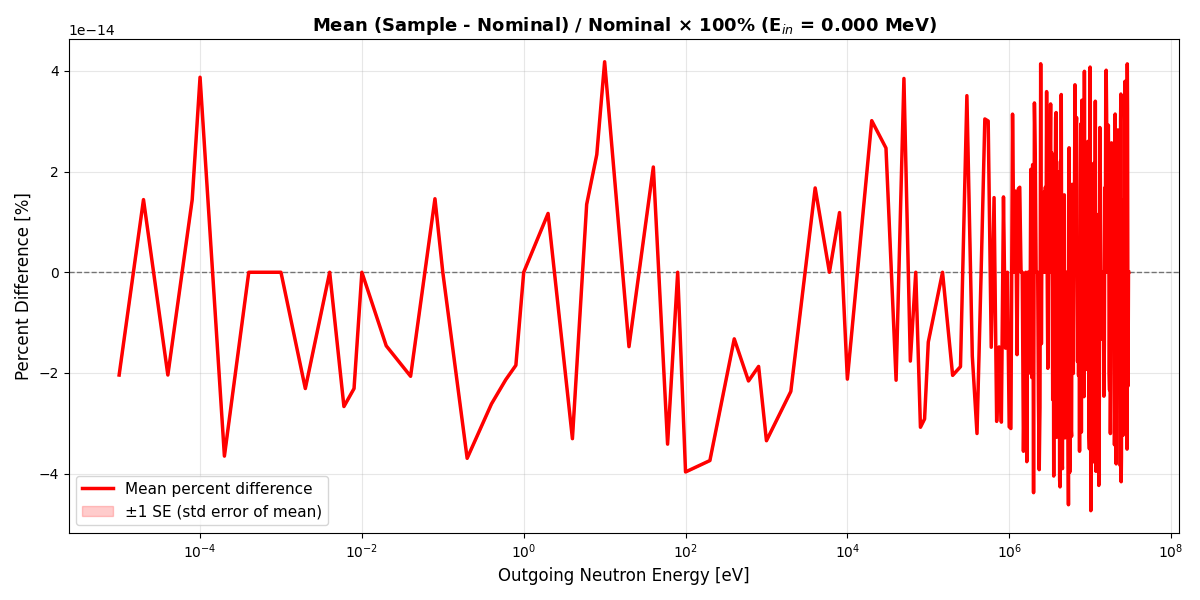

Percent difference statistics:
  Mean: -0.000%
  Std dev: 0.000%
  Min: -0.000%
  Max: 0.000%


In [17]:
fig, ax = plt.subplots(figsize=(12, 6))

# Plot mean difference
ax.plot(nominal_energies, percent_diff_mean, 'r-', linewidth=2.5, label='Mean percent difference', zorder=10)

# Add ±1σ confidence band (standard error of the mean)
percent_diff_std = np.std(percent_diff_individual, axis=0)
std_error = percent_diff_std / np.sqrt(len(sampled_probs_list))
ax.fill_between(nominal_energies,
                 percent_diff_mean - std_error,
                 percent_diff_mean + std_error,
                 color='red', alpha=0.2, label='±1 SE (std error of mean)')

# Add zero reference line
ax.axhline(0, color='k', linestyle='--', linewidth=1, alpha=0.5, zorder=5)

ax.set_xlabel('Outgoing Neutron Energy [eV]', fontsize=12)
ax.set_ylabel('Percent Difference [%]', fontsize=12)
ax.set_title(f'Mean (Sample - Nominal) / Nominal × 100% (E$_{{in}}$ = {incident_energy/1e6:.3f} MeV)', 
             fontsize=13, fontweight='bold')
ax.set_xscale('log')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistics
print(f"Percent difference statistics:")
print(f"  Mean: {np.mean(percent_diff_mean):.3f}%")
print(f"  Std dev: {np.std(percent_diff_mean):.3f}%")
print(f"  Min: {np.min(percent_diff_mean):.3f}%")
print(f"  Max: {np.max(percent_diff_mean):.3f}%")

## Plot 3: Expected vs Sample Relative Standard Deviation

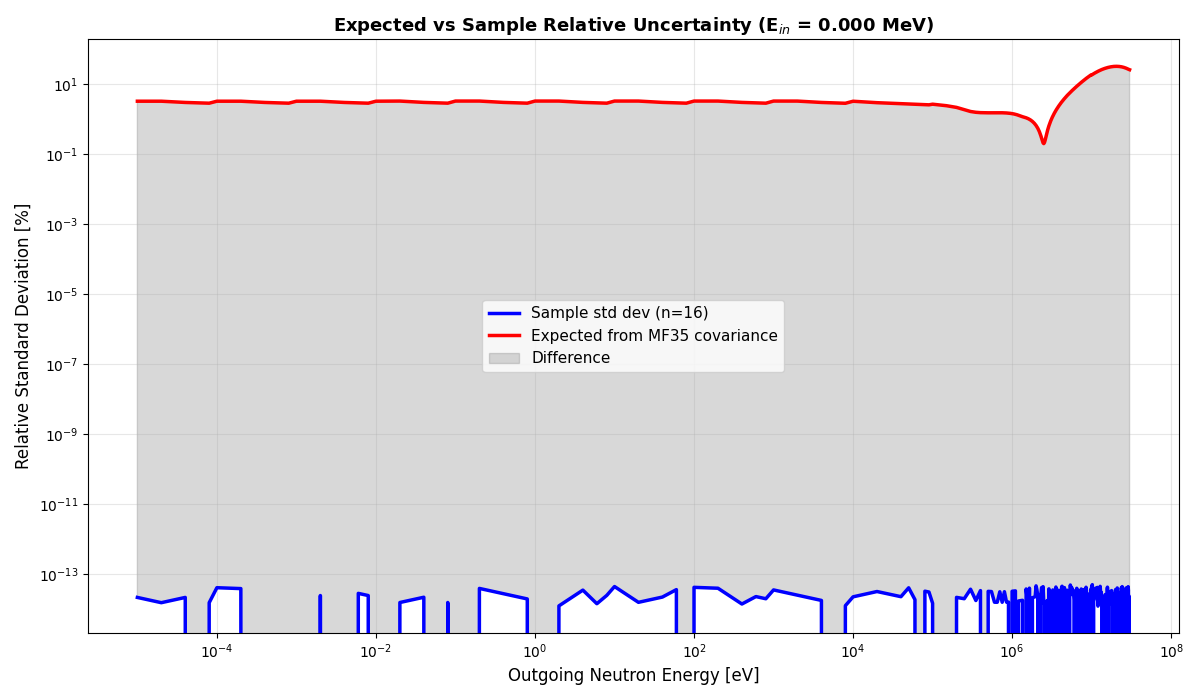


Comparison: Sample vs Expected relative std dev:
  Mean ratio (sample/expected): 0.000
  Median ratio: 0.000
  Ratio range: [0.000, 0.000]
  Mean absolute percent difference: 12.50%


In [18]:
fig, ax = plt.subplots(figsize=(12, 7))

# Plot sample relative standard deviation
ax.plot(nominal_energies, sample_rel_std * 100, 'b-', linewidth=2.5, 
        label=f'Sample std dev (n={len(sampled_probs_list)})', zorder=10)

# Plot expected relative uncertainty from MF35 if available
if has_covariance and block_idx is not None:
    ax.plot(nominal_energies, expected_rel_unc_mapped * 100, 'r-', linewidth=2.5, 
            label='Expected from MF35 covariance', zorder=10)
    
    # Fill between to show agreement
    ax.fill_between(nominal_energies, 
                     sample_rel_std * 100, 
                     expected_rel_unc_mapped * 100,
                     color='gray', alpha=0.3, label='Difference')

ax.set_xlabel('Outgoing Neutron Energy [eV]', fontsize=12)
ax.set_ylabel('Relative Standard Deviation [%]', fontsize=12)
ax.set_title(f'Expected vs Sample Relative Uncertainty (E$_{{in}}$ = {incident_energy/1e6:.3f} MeV)', 
             fontsize=13, fontweight='bold')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print comparison statistics if covariance available
if has_covariance and block_idx is not None:
    # Compare only where both are defined and positive
    valid_mask = (sample_rel_std > 0) & (expected_rel_unc_mapped > 0)
    ratio = sample_rel_std[valid_mask] / expected_rel_unc_mapped[valid_mask]
    
    print(f"\nComparison: Sample vs Expected relative std dev:")
    print(f"  Mean ratio (sample/expected): {np.mean(ratio):.3f}")
    print(f"  Median ratio: {np.median(ratio):.3f}")
    print(f"  Ratio range: [{np.min(ratio):.3f}, {np.max(ratio):.3f}]")
    print(f"  Mean absolute percent difference: {np.mean(np.abs(sample_rel_std[valid_mask] - expected_rel_unc_mapped[valid_mask]) * 100):.2f}%")

## Combined Summary Plot

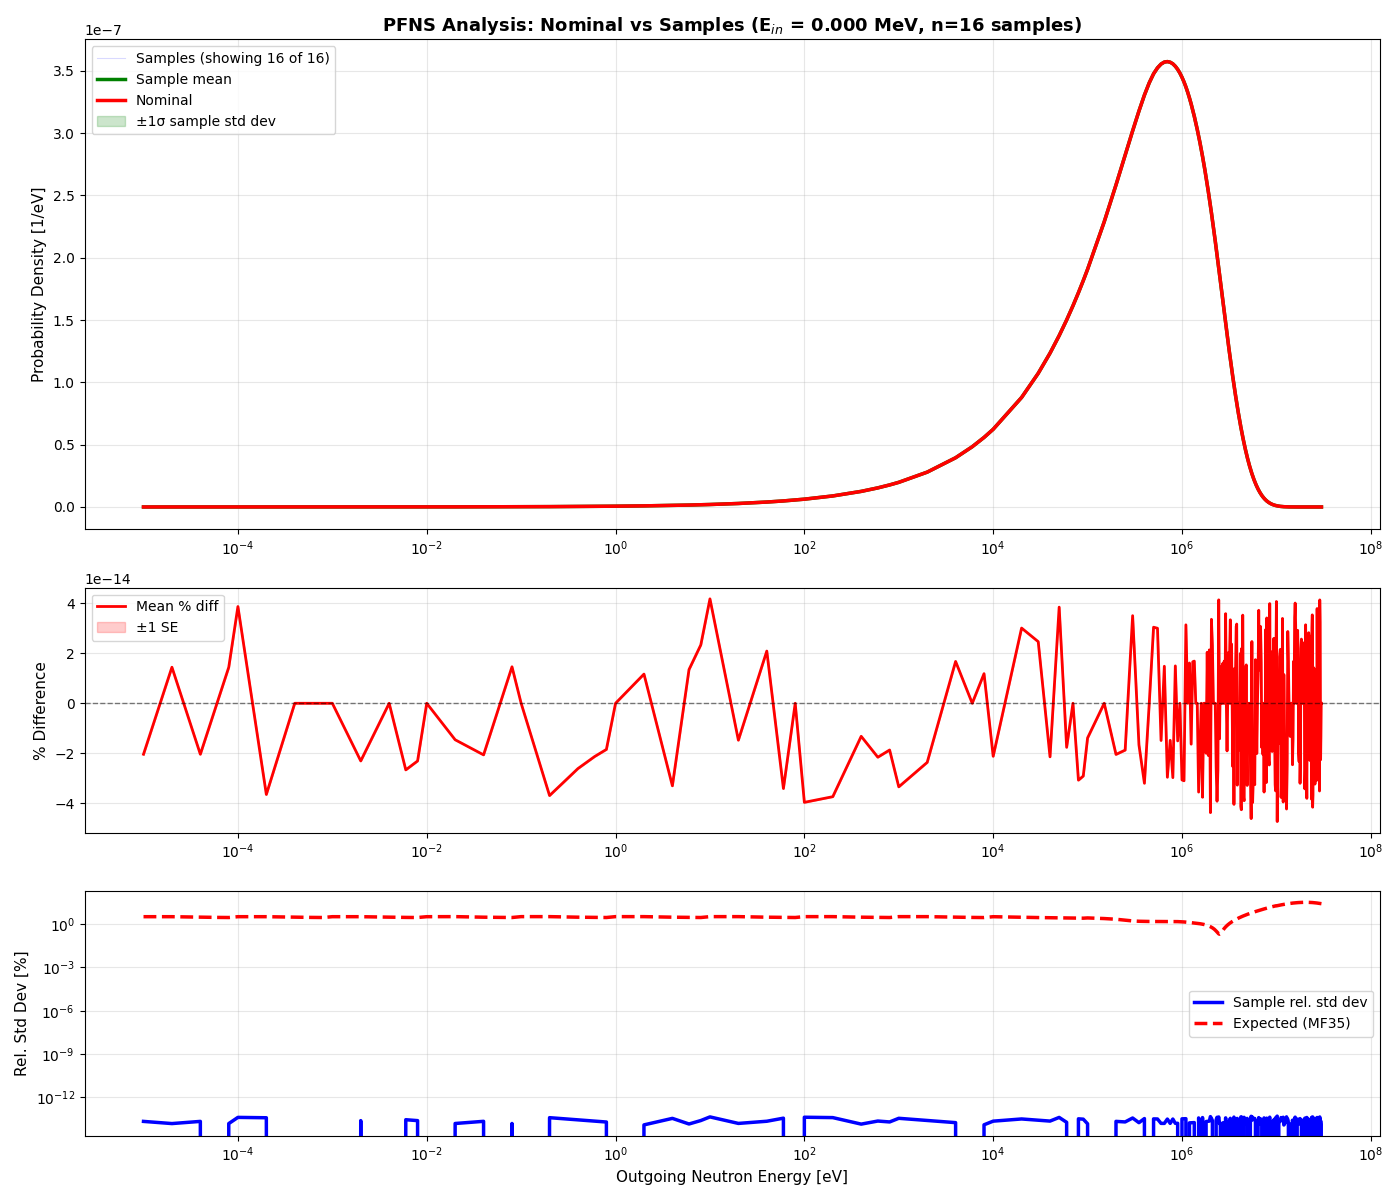

In [19]:
fig, axes = plt.subplots(3, 1, figsize=(14, 12), height_ratios=[2, 1, 1])

# Panel 1: PFNS Spectra
ax1 = axes[0]
for i, probs in enumerate(sampled_probs_list[:min(50, len(sampled_probs_list))]):
    if i == 0:
        ax1.plot(nominal_energies, probs, 'b-', alpha=0.15, linewidth=0.8, 
                label=f'Samples (showing {min(50, len(sampled_probs_list))} of {len(sampled_probs_list)})')
    else:
        ax1.plot(nominal_energies, probs, 'b-', alpha=0.15, linewidth=0.8)

ax1.plot(nominal_energies, sample_mean, 'g-', linewidth=2.5, label='Sample mean', zorder=10)
ax1.plot(nominal_energies, nominal_probs, 'r-', linewidth=2.5, label='Nominal', zorder=10)

# Add uncertainty band
ax1.fill_between(nominal_energies, 
                 sample_mean - sample_std, 
                 sample_mean + sample_std,
                 color='green', alpha=0.2, label='±1σ sample std dev')

ax1.set_ylabel('Probability Density [1/eV]', fontsize=11)
ax1.set_title(f'PFNS Analysis: Nominal vs Samples (E$_{{in}}$ = {incident_energy/1e6:.3f} MeV, n={len(sampled_probs_list)} samples)', 
             fontsize=13, fontweight='bold')
ax1.set_xscale('log')
# ax1.set_yscale('log')
ax1.legend(fontsize=10, loc='best')
ax1.grid(True, alpha=0.3)

# Panel 2: Percent Difference
ax2 = axes[1]
ax2.plot(nominal_energies, percent_diff_mean, 'r-', linewidth=2, label='Mean % diff')
ax2.axhline(0, color='k', linestyle='--', linewidth=1, alpha=0.5)

# Add ±1 standard error band (uncertainty on the mean)
percent_diff_std = np.std(percent_diff_individual, axis=0)
std_error = percent_diff_std / np.sqrt(len(sampled_probs_list))
ax2.fill_between(nominal_energies,
                 percent_diff_mean - std_error,
                 percent_diff_mean + std_error,
                 color='red', alpha=0.2, label='±1 SE')

ax2.set_ylabel('% Difference', fontsize=11)
ax2.set_xscale('log')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# Panel 3: Relative Uncertainties
ax3 = axes[2]
ax3.plot(nominal_energies, sample_rel_std * 100, 'b-', linewidth=2.5, label='Sample rel. std dev')

if has_covariance and block_idx is not None:
    ax3.plot(nominal_energies, expected_rel_unc_mapped * 100, 'r--', linewidth=2.5, 
            label='Expected (MF35)')

ax3.set_xlabel('Outgoing Neutron Energy [eV]', fontsize=11)
ax3.set_ylabel('Rel. Std Dev [%]', fontsize=11)
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
%matplotlib widget

## Summary Statistics

In [20]:
print("="*70)
print("PFNS SAMPLING VALIDATION SUMMARY")
print("="*70)

print(f"\nData Information:")
print(f"  Nominal file: {Path(nominal_file).name}")
print(f"  Number of samples: {len(sampled_probs_list)}")
print(f"  Incident energy: {incident_energy:.2e} eV = {incident_energy/1e6:.3f} MeV")
print(f"  Number of energy points: {len(nominal_energies)}")

print(f"\nSample vs Nominal Comparison:")
print(f"  Mean percent difference: {np.mean(percent_diff_mean):.3f}%")
print(f"  RMS percent difference: {np.sqrt(np.mean(percent_diff_mean**2)):.3f}%")
print(f"  Max absolute % diff: {np.max(np.abs(percent_diff_mean)):.3f}%")

print(f"\nSample Statistics:")
print(f"  Mean relative std dev: {np.mean(sample_rel_std)*100:.3f}%")
print(f"  Median relative std dev: {np.median(sample_rel_std)*100:.3f}%")
print(f"  Range: [{np.min(sample_rel_std)*100:.3f}%, {np.max(sample_rel_std)*100:.3f}%]")

if has_covariance and block_idx is not None:
    print(f"\nExpected Uncertainties (MF35):")
    print(f"  Mean relative uncertainty: {np.mean(expected_rel_unc)*100:.3f}%")
    print(f"  Median relative uncertainty: {np.median(expected_rel_unc)*100:.3f}%")
    print(f"  Range: [{np.min(expected_rel_unc)*100:.3f}%, {np.max(expected_rel_unc)*100:.3f}%]")
    
    valid_mask = (sample_rel_std > 0) & (expected_rel_unc_mapped > 0)
    ratio = sample_rel_std[valid_mask] / expected_rel_unc_mapped[valid_mask]
    print(f"\nValidation (Sample/Expected ratio):")
    print(f"  Mean: {np.mean(ratio):.3f}")
    print(f"  Median: {np.median(ratio):.3f}")
    print(f"  Range: [{np.min(ratio):.3f}, {np.max(ratio):.3f}]")
    
    if 0.8 <= np.median(ratio) <= 1.2:
        print(f"  ✓ Good agreement (median within 20% of expected)")
    else:
        print(f"  ⚠️  Significant deviation (median > 20% from expected)")

print("="*70)

PFNS SAMPLING VALIDATION SUMMARY

Data Information:
  Nominal file: n_92-U-235g.jeff
  Number of samples: 16
  Incident energy: 1.00e-05 eV = 0.000 MeV
  Number of energy points: 303

Sample vs Nominal Comparison:
  Mean percent difference: -0.000%
  RMS percent difference: 0.000%
  Max absolute % diff: 0.000%

Sample Statistics:
  Mean relative std dev: 0.000%
  Median relative std dev: 0.000%
  Range: [0.000%, 0.000%]

Expected Uncertainties (MF35):
  Mean relative uncertainty: 12.767%
  Median relative uncertainty: 4.833%
  Range: [0.203%, 33.014%]

Validation (Sample/Expected ratio):
  Mean: 0.000
  Median: 0.000
  Range: [0.000, 0.000]
  ⚠️  Significant deviation (median > 20% from expected)
